In [48]:
'''
compare two implementations of price oracle:
    arithmetic mean used by uniswap v2
    geometric mean used by uniswap v3
'''

from functools import reduce
import math
import pandas as pd
import numpy as np


In [49]:
# tick index is log(price, 1.0001)
LOG_BASE = 1.0001
time_index = [0,1,3,6,9,11,12,13,16,20,22,24,26,28,32,36]
# 7th element is a hostile price (price 30)
origin_prices = [100,130,110,120,100,110,30,120,110,120,100,90,80,100,120,150]

# delta time of every besides price
# first element is 0s
delta_times = [0]
for i in range(1, len(time_index)):
    delta_times.append(time_index[i] - time_index[i-1])
    

In [50]:
# uniswap V2 use arithmetic sum
def arithmetic_sums_calc(begin, end):
    sums = []
    for i in range(begin, end):
        if i == 0:
            sums.append(origin_prices[0])
        else:
            # sum = current_price * delta time
            sums.append(origin_prices[begin+i] * delta_times[begin+i])
    return sums

# uniswap V3 use geometric sum
def geometric_sums_calc(begin, end):
    sums = []
    for i in range(begin, end):
        if i == 0:
            sums.append(math.log(origin_prices[0], LOG_BASE))
        else:
            # sum = current_price * delta time
            sums.append(math.log(origin_prices[begin+i], LOG_BASE) * delta_times[begin+i])
    return sums

arithmetic_sums = arithmetic_sums_calc(0, len(origin_prices))
geometric_sums = geometric_sums_calc(0, len(origin_prices))

print(arithmetic_sums)
print(geometric_sums)

[100, 130, 220, 360, 300, 220, 30, 120, 330, 480, 200, 180, 160, 200, 480, 600]
[46054.00440660449, 48677.77823122565, 94014.30771788706, 143631.93340141006, 138162.01321981347, 94014.30771788706, 34013.674386974235, 47877.311133803356, 141021.4615768306, 191509.24453521342, 92108.00881320897, 90000.69314129246, 87644.91464709182, 92108.00881320897, 191509.24453521342, 200435.43286744767]


In [51]:
# the cumulative price store in oracle
cumulative_arithmetic = []
cumulative_geometric = []

for i in range(1,len(origin_prices)+1):
    cumulative_arithmetic.append(reduce(lambda x,y: x+y, arithmetic_sums[0:i]))
    cumulative_geometric.append(reduce(lambda x,y: x+y, geometric_sums[0:i]))

print(cumulative_arithmetic)
print(cumulative_geometric)


[100, 230, 450, 810, 1110, 1330, 1360, 1480, 1810, 2290, 2490, 2670, 2830, 3030, 3510, 4110]
[46054.00440660449, 94731.78263783014, 188746.0903557172, 332378.02375712723, 470540.0369769407, 564554.3446948278, 598568.019081802, 646445.3302156053, 787466.7917924359, 978976.0363276494, 1071084.0451408583, 1161084.7382821508, 1248729.6529292427, 1340837.6617424516, 1532346.906277665, 1732782.3391451125]


In [52]:
# calc price with oracle's cumulative price
def calc_arithmetic_oracleprice(begin,end):
    return (cumulative_arithmetic[end] - cumulative_arithmetic[begin]) / (time_index[end] - time_index[begin])

def calc_geometric_oracleprice(begin,end):
    return math.pow(LOG_BASE, (cumulative_geometric[end] - cumulative_geometric[begin]) / (time_index[end] - time_index[begin]))

WINDOW_SIZE = 4

np_mean_prices = []
oracle_arithmetic_prices = []
oracle_geometric_prices = []

for i in range(0,len(origin_prices)):
    if i < WINDOW_SIZE:
        np_mean_prices.append(None)
        oracle_arithmetic_prices.append(None)
        oracle_geometric_prices.append(None)
    else:
        np_mean_prices.append(np.mean(origin_prices[i-WINDOW_SIZE:i]))
        oracle_arithmetic_prices.append(calc_arithmetic_oracleprice(i-WINDOW_SIZE,i))
        oracle_geometric_prices.append(calc_geometric_oracleprice(i-WINDOW_SIZE,i))

df = pd.DataFrame({
  'time_index': time_index,
  'price': origin_prices,
  'delta_times': delta_times,
  'cumulative_arithmetic': cumulative_arithmetic,
  'cumulative_geometric': cumulative_geometric,
  'oracle_arithmetic_prices': oracle_arithmetic_prices,
  'oracle_geometric_prices': oracle_geometric_prices,
})

# the result showing arithmetic mean is more stable than geometric mean
# that's weird...
print(df)


    time_index  price  delta_times  cumulative_arithmetic  \
0            0    100            0                    100   
1            1    130            1                    230   
2            3    110            2                    450   
3            6    120            3                    810   
4            9    100            3                   1110   
5           11    110            2                   1330   
6           12     30            1                   1360   
7           13    120            1                   1480   
8           16    110            3                   1810   
9           20    120            4                   2290   
10          22    100            2                   2490   
11          24     90            2                   2670   
12          26     80            2                   2830   
13          28    100            2                   3030   
14          32    120            4                   3510   
15          36    150   

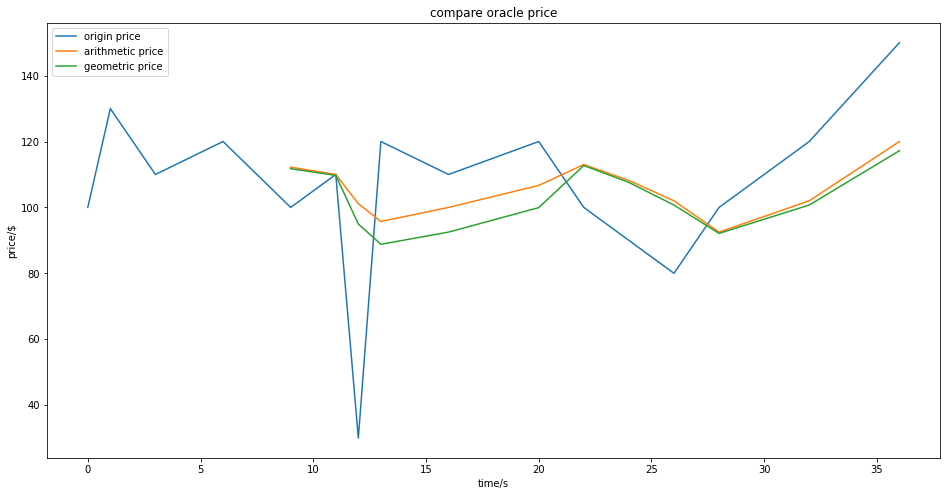

In [55]:
'''
arithmetic mean is more stable than geometric mean.
time 12s 
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(time_index, origin_prices, label="origin price")
plt.plot(time_index, oracle_arithmetic_prices, label="arithmetic price")
plt.plot(time_index, oracle_geometric_prices, label="geometric price")
plt.legend()
plt.xlabel('time/s')
plt.ylabel('price/$')
plt.title('compare oracle price')
plt.show()